# A/B Testing and Analyzing Result of an online store.

I'am an analyst at a big online store. Together with the marketing department, I've compiled a list of hypotheses that may help boost revenue.                                                                             

I need to prioritize these hypotheses, launch an A/B test, and analyze the results.

## Description of the data
Data used in the first part of the project                                                                                     

/datasets/hypotheses_us.csv Download dataset                                                                                   
Hypotheses — brief descriptions of the hypotheses                                                                               
Reach — user reach, on a scale of one to ten                                                                                   
Impact — impact on users, on a scale of one to ten                                                                
Confidence — confidence in the hypothesis, on a scale of one to ten                                                             
Effort — the resources required to test a hypothesis, on a scale of one to ten. The higher the Effort value, the more resource-intensive the test.                                                                                    
                                                                                                                               
Data used in the second part of the project                                                                                    
/datasets/orders_us.csv Download dataset                                                                                    
transactionId — order identifier                                                                                    
visitorId — identifier of the user who placed the order                                                                         
date — of the order                                                                                                            
revenue — from the order
group — the A/B test group that the user belongs to                                                                             

/datasets/visits_us.csv Download dataset                                                                                       
date — date                                                                                                                     
group — A/B test group                                                                                                         
visits — the number of visits on the date specified in the A/B test group specified

<div class="alert alert-block alert-warning">
<b>Reviewer's comment v.1</b> 
    
📝 Good start with a brief introduction. However, we could also add `the table of content` and describe the main AB test stages (or its design).
</div>

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import math as mt
from functools import reduce

## Data Preprocessing                                                           

In [2]:
hypotheses_us= pd.read_csv('/datasets/hypotheses_us.csv',sep=';')
hypotheses_us.head()

,Hypothesis,Reach,Impact,Confidence,Effort
0,Add two new channels for attracting traffic. T...,3,10,8,6
1,Launch your own delivery service. This will sh...,2,5,4,10
2,Add product recommendation blocks to the store...,8,3,7,3
3,Change the category structure. This will incre...,8,3,3,8
4,Change the background color on the main page. ...,3,1,1,1


In [3]:
hypotheses_us.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Effort      9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


In [4]:
hypotheses_us.columns=['hypothesis','reach', 'impact', 'confidence', 'effort']

In [5]:
hypotheses_us.head()

,hypothesis,reach,impact,confidence,effort
0,Add two new channels for attracting traffic. T...,3,10,8,6
1,Launch your own delivery service. This will sh...,2,5,4,10
2,Add product recommendation blocks to the store...,8,3,7,3
3,Change the category structure. This will incre...,8,3,3,8
4,Change the background color on the main page. ...,3,1,1,1


In [6]:
pd.set_option('max_colwidth', 450)
hypotheses_us

,hypothesis,reach,impact,confidence,effort
0,Add two new channels for attracting traffic. This will bring 30% more users,3,10,8,6
1,Launch your own delivery service. This will shorten delivery time,2,5,4,10
2,Add product recommendation blocks to the store's site. This will increase conversion and average purchase size,8,3,7,3
3,Change the category structure. This will increase conversion since users will find the products they want more quickly,8,3,3,8
4,Change the background color on the main page. This will increase user engagement,3,1,1,1
5,Add a customer review page. This will increase the number of orders,3,2,2,3
6,Show banners with current offers and sales on the main page. This will boost conversion,5,3,8,3
7,Add a subscription form to all the main pages. This will help you compile a mailing list,10,7,8,5
8,Launch a promotion that gives users discounts on their birthdays,1,9,9,5


In [7]:
hypotheses_us.isna().sum()

hypothesis    0
reach         0
impact        0
confidence    0
effort        0
dtype: int64

In [8]:
hypotheses_us.duplicated().sum()

0

Hypotheses table consists of 5 columns and 9 entries and no missing data.

In [9]:
order_us=pd.read_csv('/datasets/orders_us.csv')
order_us.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,30.4,B
1,2804400009,3642806036,2019-08-15,15.2,B
2,2961555356,4069496402,2019-08-15,10.2,A
3,3797467345,1196621759,2019-08-15,155.1,B
4,2282983706,2322279887,2019-08-15,40.5,B


In [10]:
order_us.columns=['transaction_id','visitor_id','date','revenue','group']

In [11]:
order_us.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   transaction_id  1197 non-null   int64  
 1   visitor_id      1197 non-null   int64  
 2   date            1197 non-null   object 
 3   revenue         1197 non-null   float64
 4   group           1197 non-null   object 
dtypes: float64(1), int64(2), object(2)
memory usage: 46.9+ KB


In [12]:
order_us['date']= pd.to_datetime(order_us['date'], format='%Y-%m-%d')

In [13]:
order_us.isna().sum()

transaction_id    0
visitor_id        0
date              0
revenue           0
group             0
dtype: int64

In [14]:
order_us.duplicated().sum()

0

In [15]:
## some of the visitors might have gotten into both group A and group B.
dual_group= order_us.groupby('visitor_id').agg({'group':'nunique'}).reset_index()
dual_group=dual_group.query('group>1')
dual_group.head()

,visitor_id,group
2,8300375,2
44,199603092,2
51,232979603,2
55,237748145,2
66,276558944,2


In [16]:
dual_group.shape[0]

58

There are 58 visitors in both Group A and B. 

The order table consisted of 5 columns and 1197 entries and no missing data. The date column was converted from object to datetime.

In [17]:
visits_us= pd.read_csv('/datasets/visits_us.csv')
visits_us.head()

,date,group,visits
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [18]:
visits_us.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    62 non-null     object
 1   group   62 non-null     object
 2   visits  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


In [19]:
visits_us['date']= pd.to_datetime(visits_us['date'], format='%Y-%m-%d')

In [20]:
visits_us.isna().sum()

date      0
group     0
visits    0
dtype: int64

In [21]:
visits_us.duplicated().sum()

0

The visit table consits of 3 columns and  62 entries and no missing colums. The date column was converted from object to datetime.

## Part 1. Prioritizing Hypotheses

The file hypotheses_us.csv contains nine hypotheses on boosting an online store's revenue with Reach, Impact, Confidence, and Effort specified for each.

The ICE method tasks are rated with Impact, Confidence, and Effort/Ease:                                                        
ICE Score= Impact x Confidence x Ease                                                                                           
ICE Score= (Impact x Confidence) / Effort     

The RICE method tasks are rated with four components- Reach, Impact, Confidence, and Effort:                                                        
RICE Score= (Reach x Impact x Confidence) / Effort                                                                                                                                                                              

In [22]:
## Apply the ICE framework to prioritize hypotheses. Sort them in descending order of priority.
hypotheses_us['ICE']= ((hypotheses_us['impact'] * hypotheses_us['confidence'])/hypotheses_us['effort']).round(2)

hypotheses_us[['hypothesis', 'ICE']].sort_values(by='ICE', ascending=False)

,hypothesis,ICE
8,Launch a promotion that gives users discounts on their birthdays,16.20
0,Add two new channels for attracting traffic. This will bring 30% more users,13.33
7,Add a subscription form to all the main pages. This will help you compile a mailing list,11.20
6,Show banners with current offers and sales on the main page. This will boost conversion,8.00
2,Add product recommendation blocks to the store's site. This will increase conversion and average purchase size,7.00
1,Launch your own delivery service. This will shorten delivery time,2.00
5,Add a customer review page. This will increase the number of orders,1.33
3,Change the category structure. This will increase conversion since users will find the products they want more quickly,1.12
4,Change the background color on the main page. This will increase user engagement,1.00


In [23]:
## Apply the RICE framework to prioritize hypotheses. Sort them in descending order of priority.  
hypotheses_us['RICE']= ((hypotheses_us['reach'] * hypotheses_us['impact'] * hypotheses_us['confidence']) /hypotheses_us['effort']).round(2)

hypotheses_us[['hypothesis', 'RICE']].sort_values(by='RICE', ascending=False)

,hypothesis,RICE
7,Add a subscription form to all the main pages. This will help you compile a mailing list,112.0
2,Add product recommendation blocks to the store's site. This will increase conversion and average purchase size,56.0
0,Add two new channels for attracting traffic. This will bring 30% more users,40.0
6,Show banners with current offers and sales on the main page. This will boost conversion,40.0
8,Launch a promotion that gives users discounts on their birthdays,16.2
3,Change the category structure. This will increase conversion since users will find the products they want more quickly,9.0
1,Launch your own delivery service. This will shorten delivery time,4.0
5,Add a customer review page. This will increase the number of orders,4.0
4,Change the background color on the main page. This will increase user engagement,3.0


In [24]:
hypotheses_us.head()

,hypothesis,reach,impact,confidence,effort,ICE,RICE
0,Add two new channels for attracting traffic. This will bring 30% more users,3,10,8,6,13.33,40.0
1,Launch your own delivery service. This will shorten delivery time,2,5,4,10,2.00,4.0
2,Add product recommendation blocks to the store's site. This will increase conversion and average purchase size,8,3,7,3,7.00,56.0
3,Change the category structure. This will increase conversion since users will find the products they want more quickly,8,3,3,8,1.12,9.0
4,Change the background color on the main page. This will increase user engagement,3,1,1,1,1.00,3.0


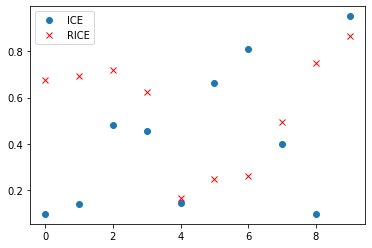

In [25]:
## Show how the prioritization of hypotheses changes when you use RICE instead of ICE. 
d = {'ICE' : np.random.rand(10),
     'RICE' : np.random.rand(10)}

df = pd.DataFrame(d)

df.plot(style=['o','rx']);

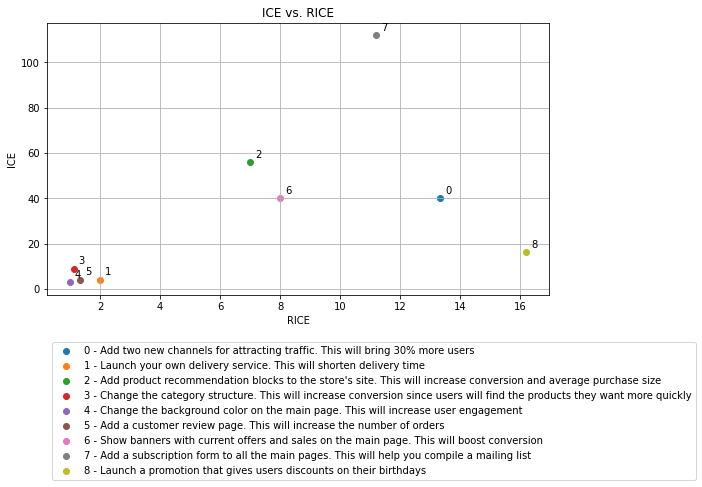

In [26]:
# The reviewer's code:
fig, ax = plt.subplots(figsize=(9, 5))

ax.set_xlabel('RICE')
ax.set_ylabel('ICE')
ax.set_title('ICE vs. RICE')

for i, txt in enumerate(hypotheses_us.index.values):
    legend = (str(txt) + ' - ' + str(hypotheses_us['hypothesis'][i]))    
    ax.annotate(txt, (hypotheses_us['ICE'][i], hypotheses_us['RICE'][i]), xytext=(5,5), textcoords='offset points')
    plt.scatter(hypotheses_us['ICE'][i], hypotheses_us['RICE'][i], label = legend)
    
plt.grid(True)  
plt.legend(loc="lower left",  bbox_to_anchor=(0, -0.7))

plt.show()

 In the ICE metric Hypothesis 8 is in the lead followed by 0. In the RICE metric hypothesis 7 is in the lead followed by 2. Hypothesis 8 in the ICE metric is much lower than the leading hypothesis when using the RICE metric. The difference between both metrics is caused by the reach parameter, which is used to estimate  how many users will be affected by an update.

## Part 2. A/B Test Analysis
You carried out an A/B test and got the results described in the files orders_us.csv and visits_us.csv.

In [27]:
## Graph cumulative revenue by group. Make conclusions and conjectures.
orders_by_group=order_us.groupby('group').agg({'visitor_id':'nunique', 'revenue':'sum'}).reset_index()
orders_by_group.head()

,group,visitor_id,revenue
0,A,503,64554.9
1,B,586,92840.6


Group A has a total revenue of 53212 and Group B has a total revenue of 79651.2. We are going to create a table for group A and B to get more insight.

In [28]:
# the reviewer's cell:
orders_by_group.assign(av_orders_size_per_user = lambda x: x['revenue'] / x['visitor_id'])

,group,visitor_id,revenue,av_orders_size_per_user
0,A,503,64554.9,128.339761
1,B,586,92840.6,158.431058


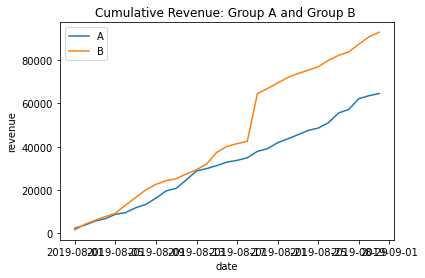

In [29]:
datesGroups = order_us[['date', 'group']].drop_duplicates()

ordersAggregated = datesGroups.apply(lambda x: order_us[np.logical_and(order_us['date'] <= x['date'], order_us['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'transaction_id' : pd.Series.nunique, 'visitor_id' : pd.Series.nunique, 'revenue' : 'sum'}), axis=1).sort_values(by=['date','group'])

visitsAggregated = datesGroups.apply(lambda x: visits_us[np.logical_and(visits_us['date'] <= x['date'], visits_us['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'visits' : 'sum'}), axis=1).sort_values(by=['date','group'])

cumulativeData = ordersAggregated.merge(visitsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']


cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')

plt.legend();
plt.title('Cumulative Revenue: Group A and Group B ');
plt.xlabel('date');
plt.ylabel('revenue');
plt.rcParams['figure.figsize'] = [8,8];

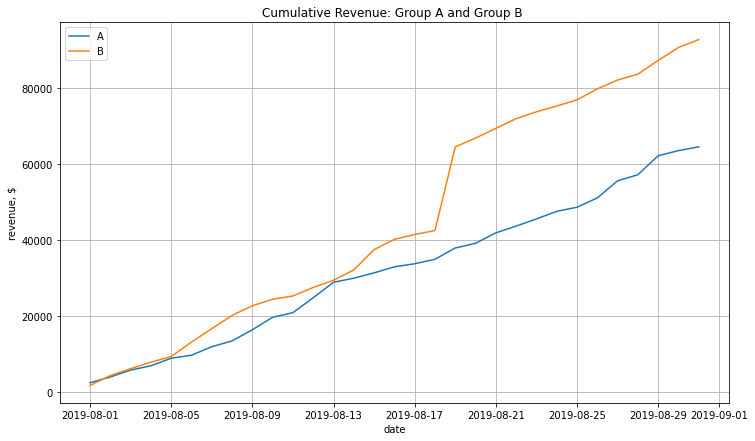

In [30]:
# the reviewer's cell:
datesGroups = order_us[['date', 'group']].drop_duplicates()

ordersAggregated = (datesGroups
                    .apply(lambda x: order_us[np.logical_and(
                        order_us['date'] <= x['date'], 
                        order_us['group'] == x['group'])]
                           .agg({'date' : 'max',
                                 'group' : 'max',
                                 'transaction_id' : pd.Series.nunique,
                                 'visitor_id' : pd.Series.nunique,
                                 'revenue' : 'sum'}), axis=1)
                    .sort_values(by=['date','group'])
                   )

visitsAggregated = (datesGroups
                    .apply(lambda x: visits_us[np.logical_and(
                        visits_us['date'] <= x['date'], 
                        visits_us['group'] == x['group'])]
                           .agg({'date' : 'max', 
                                 'group' : 'max', 
                                 'visits' : 'sum'}), axis=1)
                    .sort_values(by=['date','group'])
                   )

cumulativeData = ordersAggregated.merge(visitsAggregated, 
                                        left_on=['date', 'group'], 
                                        right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]


# here we could set the figure size:
fig = plt.figure(figsize=(12, 7))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')

plt.legend()
plt.title('Cumulative Revenue: Group A and Group B ')
plt.xlabel('date')

# please note that it is better to write the dimension of the axis:
plt.ylabel('revenue, $')

# add plot grid:
plt.grid()

# show the plot:
plt.show()

Revenue for both groups were fairly similar at the start of august. Revenue for for group B drastically increases a little after 8-17-2019 while group has a more linear growth. This may be due to pricing or the number of orders.

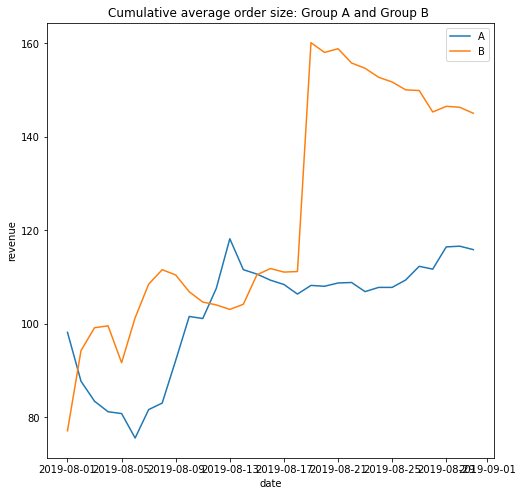

In [31]:
## Graph cumulative average order size by group. Make conclusions and conjectures.

plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.legend(); 
plt.title('Cumulative average order size: Group A and Group B ');
plt.xlabel('date');
plt.ylabel('revenue');
plt.rcParams['figure.figsize'] = [13,10];

At the beginning og August both groups fluctuate but then after 8/17/2019 the average price for Group B rises and then begins to decrease. Group A started experiencing a rise around 8/13/19 but drops a bit and then remains steady.

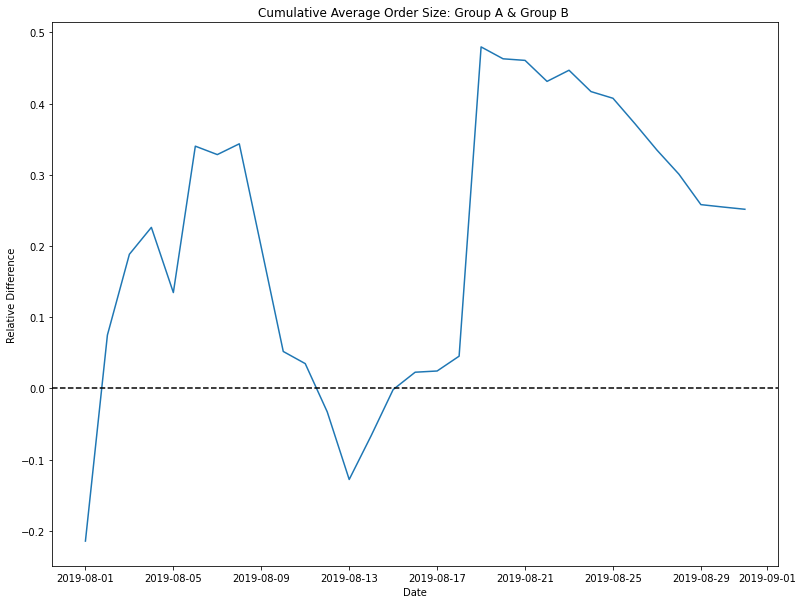

In [32]:
## Graph the relative difference in cumulative average order size for group B with group A.
## Make conclusions & conjectures.

mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)

plt.axhline(y=0, color='black', linestyle='--');
plt.title('Cumulative Average Order Size: Group A & Group B ');
plt.xlabel('Date');
plt.ylabel('Relative Difference');
plt.rcParams['figure.figsize'] = [8,12];

As shown above, there are several spikes that indicate a large order and outliers.

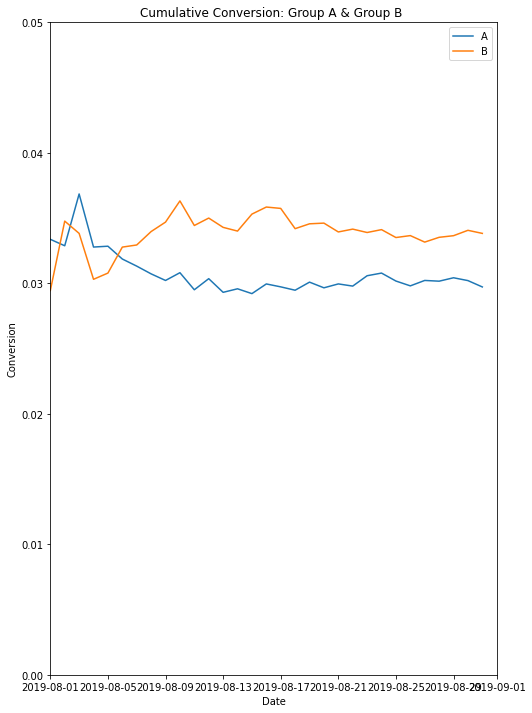

In [33]:
## Calculate each group's conversion rate as the ratio of orders to the number of visits for each day.
## plot the daily conversion rates of the two groups and describe the difference. Draw conclusions and make  conjectures.

cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.legend()

plt.axis([pd.to_datetime('2019-08-01'), pd.to_datetime('2019-09-01'), 0, 0.05])
plt.title('Cumulative Conversion: Group A & Group B ');
plt.xlabel('Date');
plt.ylabel('Conversion');
plt.rcParams['figure.figsize'] = [12,15];

Both groups show to have some fluctuation at the start with conversation rate higher for Group A. Group B then takes the lead while A decreases.

In [34]:
## Plot a scatter chart of the number of orders per user. Make conclusions and conjectures.

ordersByUsers =order_us.drop(['group', 'revenue', 'date'], axis=1).groupby('visitor_id', as_index=False).agg({'transaction_id' : pd.Series.nunique})

ordersByUsers.columns= ['user_id','orders']

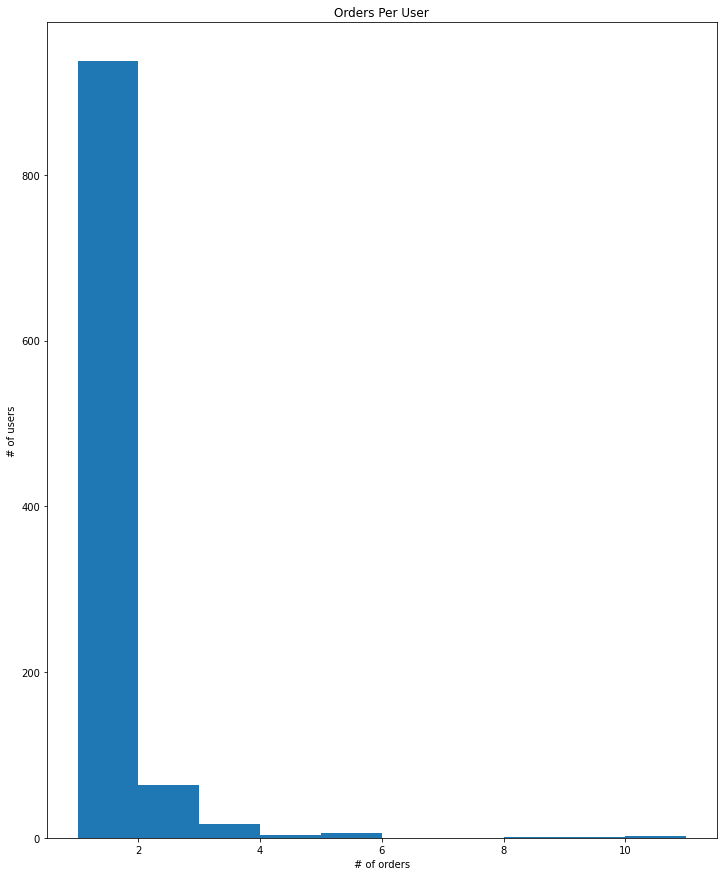

In [35]:
plt.hist(ordersByUsers['orders']);
plt.title('Orders Per User');
plt.xlabel('# of orders');
plt.ylabel('# of users');

In [36]:
ordersByUsers

,user_id,orders
0,5114589,1
1,6958315,1
2,8300375,2
3,11685486,1
4,39475350,1
...,...,...
1026,4266935830,2
1027,4278982564,1
1028,4279090005,1
1029,4281247801,1


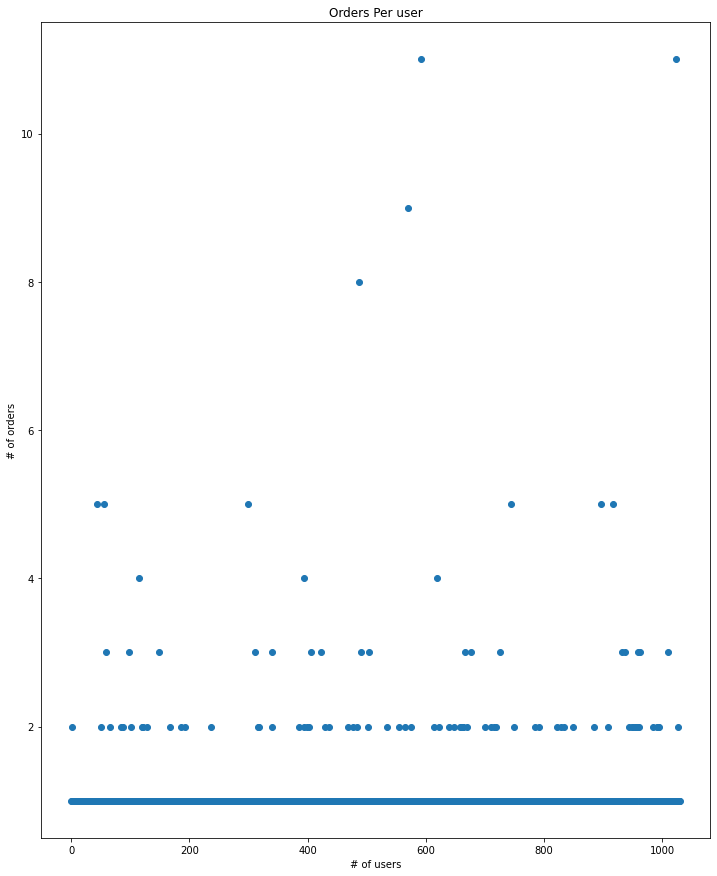

In [37]:
x_values = pd.Series(range(0,len(ordersByUsers)))
plt.scatter(x_values, ordersByUsers['orders'])
plt.title('Orders Per user');
plt.xlabel('# of users');
plt.ylabel('# of orders');

Majority of buyers made a total of 1 order, but we also see that some user buy 2 to 4 orders.

In [38]:
## Calculate the 95th and 99th sample for the number of orders per user. Define the pointat which data becomes an anomaly.

print(np.percentile(ordersByUsers['orders'], [95, 99]))

[2. 4.]


No more than 5% of users order more than twice and not more than the 1% order more than 4. 

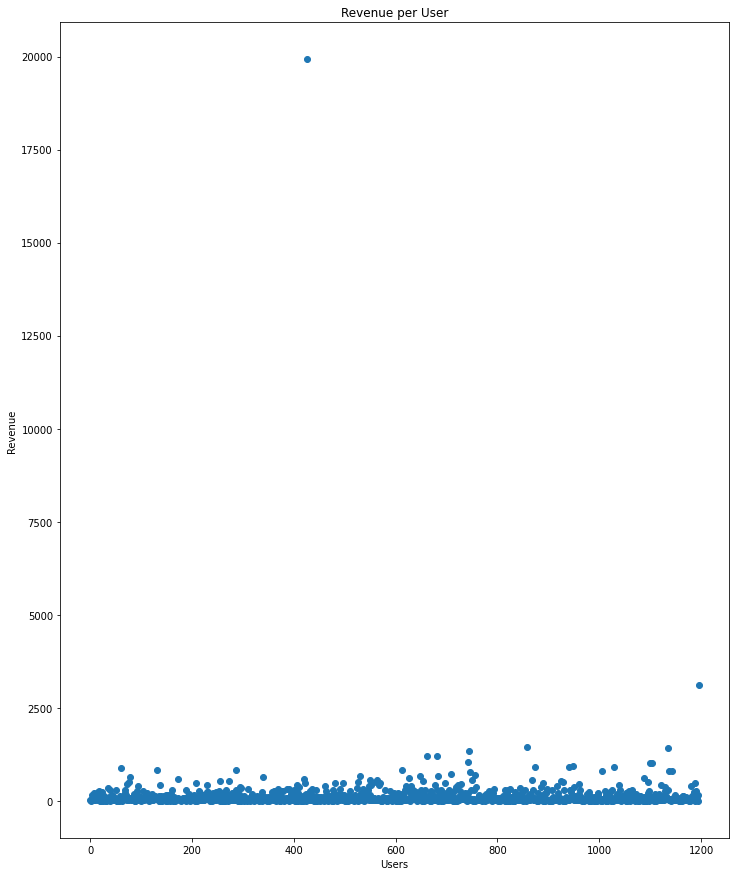

In [39]:
## plot a scatter chart of order prices. Make conclusions & conjectures.
x_values = pd.Series(range(0,len(order_us['revenue'])))
plt.scatter(x_values, order_us['revenue']);
plt.title('Revenue per User');
plt.xlabel('Users');
plt.ylabel('Revenue');

There's one order of 2500 and one of 20000, both are outliers.

In [40]:
## Calculate the 95th and 99th sample for the number of orders per user. Define the pointat which data becomes an anomaly.

print(np.percentile(order_us['revenue'], [95, 99]))

[435.54  900.904]


No more than 5% of orders cost more than 435.54, and no more than 1% cost more than 900.90.
We can set the limit at 435.54 anything above that can be seen as an anomaly. Order above 3 can also be seen as an anomaly.

We are testing the following hypothesis:  

Alpha =0.05 
   
H0: 'There is no significant difference in conversion between the groups'.                                                        
H1: 'There is a significant difference in conversion between the groups'

In [47]:
order_us

,transaction_id,visitor_id,date,revenue,group
0,3667963787,3312258926,2019-08-15,30.4,B
1,2804400009,3642806036,2019-08-15,15.2,B
2,2961555356,4069496402,2019-08-15,10.2,A
3,3797467345,1196621759,2019-08-15,155.1,B
4,2282983706,2322279887,2019-08-15,40.5,B
...,...,...,...,...,...
1192,2662137336,3733762160,2019-08-14,100.8,B
1193,2203539145,370388673,2019-08-14,50.1,A
1194,1807773912,573423106,2019-08-14,165.3,A
1195,1947021204,1614305549,2019-08-14,5.5,A


In [41]:
## Find the statistical significance of the difference in conversion between the groups using the raw data.
ordersByUsersA = order_us[order_us['group']=='A'].groupby('visitor_id', as_index=False).agg({'transaction_id' : pd.Series.nunique})
ordersByUsersA.columns = ['user_id', 'orders']

ordersByUsersB = order_us[order_us['group']=='B'].groupby('visitor_id', as_index=False).agg({'transaction_id' : pd.Series.nunique})
ordersByUsersB.columns = ['user_id', 'orders'] 

sampleA = pd.concat([ordersByUsersA['orders'],pd.Series(0, index=np.arange(visits_us[visits_us['group']=='A']['visits'].sum() - len(ordersByUsersA['orders'])), name='orders')],axis=0)

sampleB = pd.concat([ordersByUsersB['orders'],pd.Series(0, index=np.arange(visits_us[visits_us['group']=='B']['visits'].sum() - len(ordersByUsersB['orders'])), name='orders')],axis=0)

print("p-value is {0:.3f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))
print("The relative conversion is {0:.3f}".format(sampleB.mean()/sampleA.mean()-1)) 

p-value is 0.017
The relative conversion is 0.138


The first row of the output gives us the p-value, 0.017, which is less than 0.05. The relative conversion is 13.8%. The analysis shows that the conversion rates have statistical differences.

In [42]:
# the reviewer's cell:

print("p-value is {0:.3f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))
print("The relative conversion is {0:.3f}".format(sampleB.mean()/sampleA.mean()-1)) 

p-value is 0.017
The relative conversion is 0.138


We are testing the following hypothesis:  

Alpha =0.05 
   
H0: 'There is no difference in average order size between the groups'                                                         
H1: 'There is a difference in average order size between the groups'

In [43]:
## Find the statistical significance of the difference in average order size between the groups using the raw data.
print("p-value is {0:.3f}".format(stats.mannwhitneyu(order_us[order_us['group']=='A']['revenue'], order_us[order_us['group']=='B']['revenue'])[1]))
print("The relative conversion is {0:.3f}".format(order_us[order_us['group']=='B']['revenue'].mean()/order_us[order_us['group']=='A']['revenue'].mean()-1)) 

p-value is 0.692
The relative conversion is 0.252


The first row of the output gives us the p-value, 0.692, which is larger than 0.05. The relative diffference is 25.2%. we can't reject the null hypothesis that there's not a statistically significant difference average order size between the groups.

We are testing the following hypothesis:  

Alpha =0.05 
   
H0: 'There is no difference in conversion between the groups using the filtered data'                                                         
H1: 'There is a difference in conversion between the groups using the filtered data'

In [44]:
## Find the statistical significance of the difference in conversion between the groups using the filtered data. 

usersWithManyOrders = pd.concat([ordersByUsersA[ordersByUsersA['orders'] > 2]['user_id'], ordersByUsersB[ordersByUsersB['orders'] > 2]['user_id']], axis = 0)
usersWithExpensiveOrders = order_us[order_us['revenue'] > 450]['visitor_id']
abnormalUsers = pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis = 0).drop_duplicates().sort_values()

sampleAFiltered = pd.concat([ordersByUsersA[np.logical_not(ordersByUsersA['user_id'].isin(abnormalUsers))]['orders'],pd.Series(0, index=np.arange(visits_us[visits_us['group']=='A']['visits'].sum() - len(ordersByUsersA['orders'])),name='orders')],axis=0)
sampleBFiltered = pd.concat([ordersByUsersB[np.logical_not(ordersByUsersB['user_id'].isin(abnormalUsers))]['orders'],pd.Series(0, index=np.arange(visits_us[visits_us['group']=='B']['visits'].sum() - len(ordersByUsersB['orders'])),name='orders')],axis=0) 
print("p-value is {0:.5f}".format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print("The relative conversion is {0:.3f}".format(sampleBFiltered.mean()/sampleAFiltered.mean()-1)) 

p-value is 0.01324
The relative conversion is 0.172


The first row of the output gives us the p-value, 0.01324, which is less than 0.05. The relative diffference is 17.2%. we can reject the null hypothesis that there's not a statistically significant difference in conversion between the groups using the filtered data.

We are testing the following hypothesis:  

Alpha =0.05 
   
H0: 'There is no difference in average order size between the groups using the filtered data'                                                         
H1: 'There is a difference in average order size between the groups using the filtered data'

In [45]:
## Find the statistical significance of the difference in average order size between the groups using the filtered data

print("p-value is {0:.3f}".format(stats.mannwhitneyu(
    order_us[np.logical_and(
        order_us['group']=='A',
        np.logical_not(order_us['visitor_id'].isin(abnormalUsers)))]['revenue'],
    order_us[np.logical_and(
        order_us['group']=='B',
        np.logical_not(order_us['visitor_id'].isin(abnormalUsers)))]['revenue'])[1]))

print("The relative conversion is {0:.3f}".format(
    order_us[np.logical_and(order_us['group']=='B',np.logical_not(order_us['visitor_id'].isin(abnormalUsers)))]['revenue'].mean()/
    order_us[np.logical_and(
        order_us['group']=='A',
        np.logical_not(order_us['visitor_id'].isin(abnormalUsers)))]['revenue'].mean() - 1)) 

p-value is 0.776
The relative conversion is -0.021


The first row of the output gives us the p-value, 0.776, which is greater than 0.05. we can't reject the null hypothesis that there's not a statistically significant difference in average order size between the groups using the filtered data. 
The relative loss for Group B is  -2.1%

In [46]:
## Make a decision based on the test results. 
## The possible decisions are: 1. Stop the test, consider one of the groups the leader. 
## 2. Stop the test, conclude that there is no difference between the groups. 3. Continue the test

Based on the above graphs and the test ran, we can conclude the test as it was successful and has shown that Group B is in the lead. It showed us that there is a statistical difference in conversion between the groups using the raw data but no difference on statistical significance of the difference in average order size between the groups.There is a difference in conversion between the groups using the filtered data but there is no differenceaverage order size between the groups using the filtered data which means that users in Group B buy the same amount as Group A does. 